In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Lambda, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import os

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of resnet50
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# freeze existing trained  weights
for layer in resnet.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Capstone/NEW"
filenames = os.listdir(path)

df=pd.DataFrame({'filename':filenames})
df["category"] = df.apply(lambda x: x['filename'].split(' ')[0], axis=1)

# temp1 = df[df.category=='china']
# temp2 = df[df.category=='usa']
# df = pd.concat([temp1, temp2],ignore_index=True, axis = 0)
# df.category.value_counts()

train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["category"])
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42, stratify=validate_df["category"])

#resetting the index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
print(train_df.category.value_counts())
print(validate_df.category.value_counts())
print(test_df.category.value_counts())

India    7000
china    7000
usa      7000
Name: category, dtype: int64
china    1500
usa      1500
India    1500
Name: category, dtype: int64
usa      1501
china    1500
India    1500
Name: category, dtype: int64


In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_set = train_datagen.flow_from_dataframe(train_df,path,x_col='filename',
                                              y_col='category', target_size=(224, 224),
                                              class_mode='categorical',batch_size=32)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_set = validation_datagen.flow_from_dataframe(validate_df,path,x_col='filename',
                                                        y_col='category',target_size=(224, 224),
                                                        class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_dataframe(test_df,path,x_col='filename',
                                            y_col='category',target_size=(224, 224),
                                            class_mode='categorical',batch_size=32, shuffle=False)

Found 21000 validated image filenames belonging to 3 classes.
Found 4500 validated image filenames belonging to 3 classes.
Found 4501 validated image filenames belonging to 3 classes.


In [ ]:
# Add dropout layers

# x = Dense(1024, activation='relu')(resnet.output)
# x = Dense(512, activation='relu')(x)
x = Flatten()(resnet.output)

prediction = Dense(len(train_df.category.value_counts()), activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05), metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

r = model.fit(train_set,
              validation_data=validation_set,
              epochs=30,
              steps_per_epoch=len(train_set),
              validation_steps=len(validation_set),
              callbacks=[callback])

Epoch 1/30
657/657 [==============================] - 5337s 8s/step - loss: 1.0831 - accuracy: 0.4050 - val_loss: 1.0123 - val_accuracy: 0.4929
Epoch 2/30
657/657 [==============================] - 864s 1s/step - loss: 1.0090 - accuracy: 0.4856 - val_loss: 0.9872 - val_accuracy: 0.5167
Epoch 3/30
657/657 [==============================] - 856s 1s/step - loss: 0.9838 - accuracy: 0.5082 - val_loss: 0.9659 - val_accuracy: 0.5298
Epoch 4/30
657/657 [==============================] - 842s 1s/step - loss: 0.9722 - accuracy: 0.5288 - val_loss: 0.9578 - val_accuracy: 0.5360
Epoch 5/30
657/657 [==============================] - 851s 1s/step - loss: 0.9675 - accuracy: 0.5263 - val_loss: 0.9695 - val_accuracy: 0.5231
Epoch 6/30
657/657 [==============================] - 862s 1s/step - loss: 0.9596 - accuracy: 0.5306 - val_loss: 0.9670 - val_accuracy: 0.5280
Epoch 7/30
657/657 [==============================] - 794s 1s/step - loss: 0.9536 - accuracy: 0.5341 - val_loss: 0.9634 - val_accuracy: 0.512

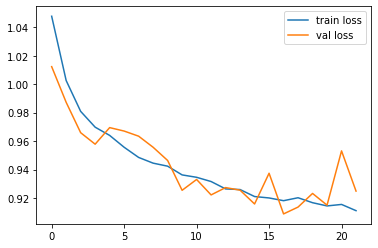

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone/RESNET50_2/RESNET50_ValLoss_2.png')
plt.show()

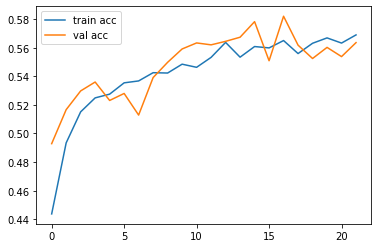

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone/RESNET50_2/RESNET50_ValACC_2.png')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone/RESNET50_2/RESNET50_2.h5')

In [ ]:
train_set.class_indices.items()

dict_items([('India', 0), ('china', 1), ('usa', 2)])

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Capstone/RESNET50_2/RESNET50_2.h5')
test_set.reset()
pred = model.predict(test_set)
test_df["pred"] = np.argmax(pred, axis=1)
test_df["pred"] = test_df["pred"].replace({0:'India',1:'china',2:'usa'})
test_df.tail()

,filename,category,pred
4496,usa (9349).jpg,usa,usa
4497,usa (305).jpg,usa,china
4498,usa (9214).jpg,usa,usa
4499,India (7229).jpg,India,India
4500,china (4093).jpg,china,china


In [ ]:
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/RESNET50_2/test_df.csv")

In [ ]:
model.evaluate(test_set, verbose=2)

141/141 - 102s - loss: 0.9085 - accuracy: 0.5783


[0.9084738492965698, 0.5783159136772156]

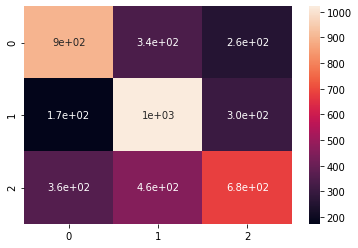

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['pred'])
sns.heatmap(cm, annot=True)

In [ ]:
target_names = [ 'india', 'china', 'usa']
classification_report(test_df['category'], test_df['pred'], target_names= target_names)

'              precision    recall  f1-score   support\n\n       india       0.63      0.60      0.61      1500\n       china       0.56      0.68      0.62      1500\n         usa       0.55      0.46      0.50      1501\n\n    accuracy                           0.58      4501\n   macro avg       0.58      0.58      0.57      4501\nweighted avg       0.58      0.58      0.57      4501\n'

In [ ]:
#               precision    recall  f1-score   support

#        india       0.63      0.60      0.61      1500
#        china       0.56      0.68      0.62      1500
#          usa       0.55      0.46      0.50      1501

#     accuracy                           0.58      4501
#    macro avg       0.58      0.58      0.57      4501
# weighted avg       0.58      0.58      0.57      4501

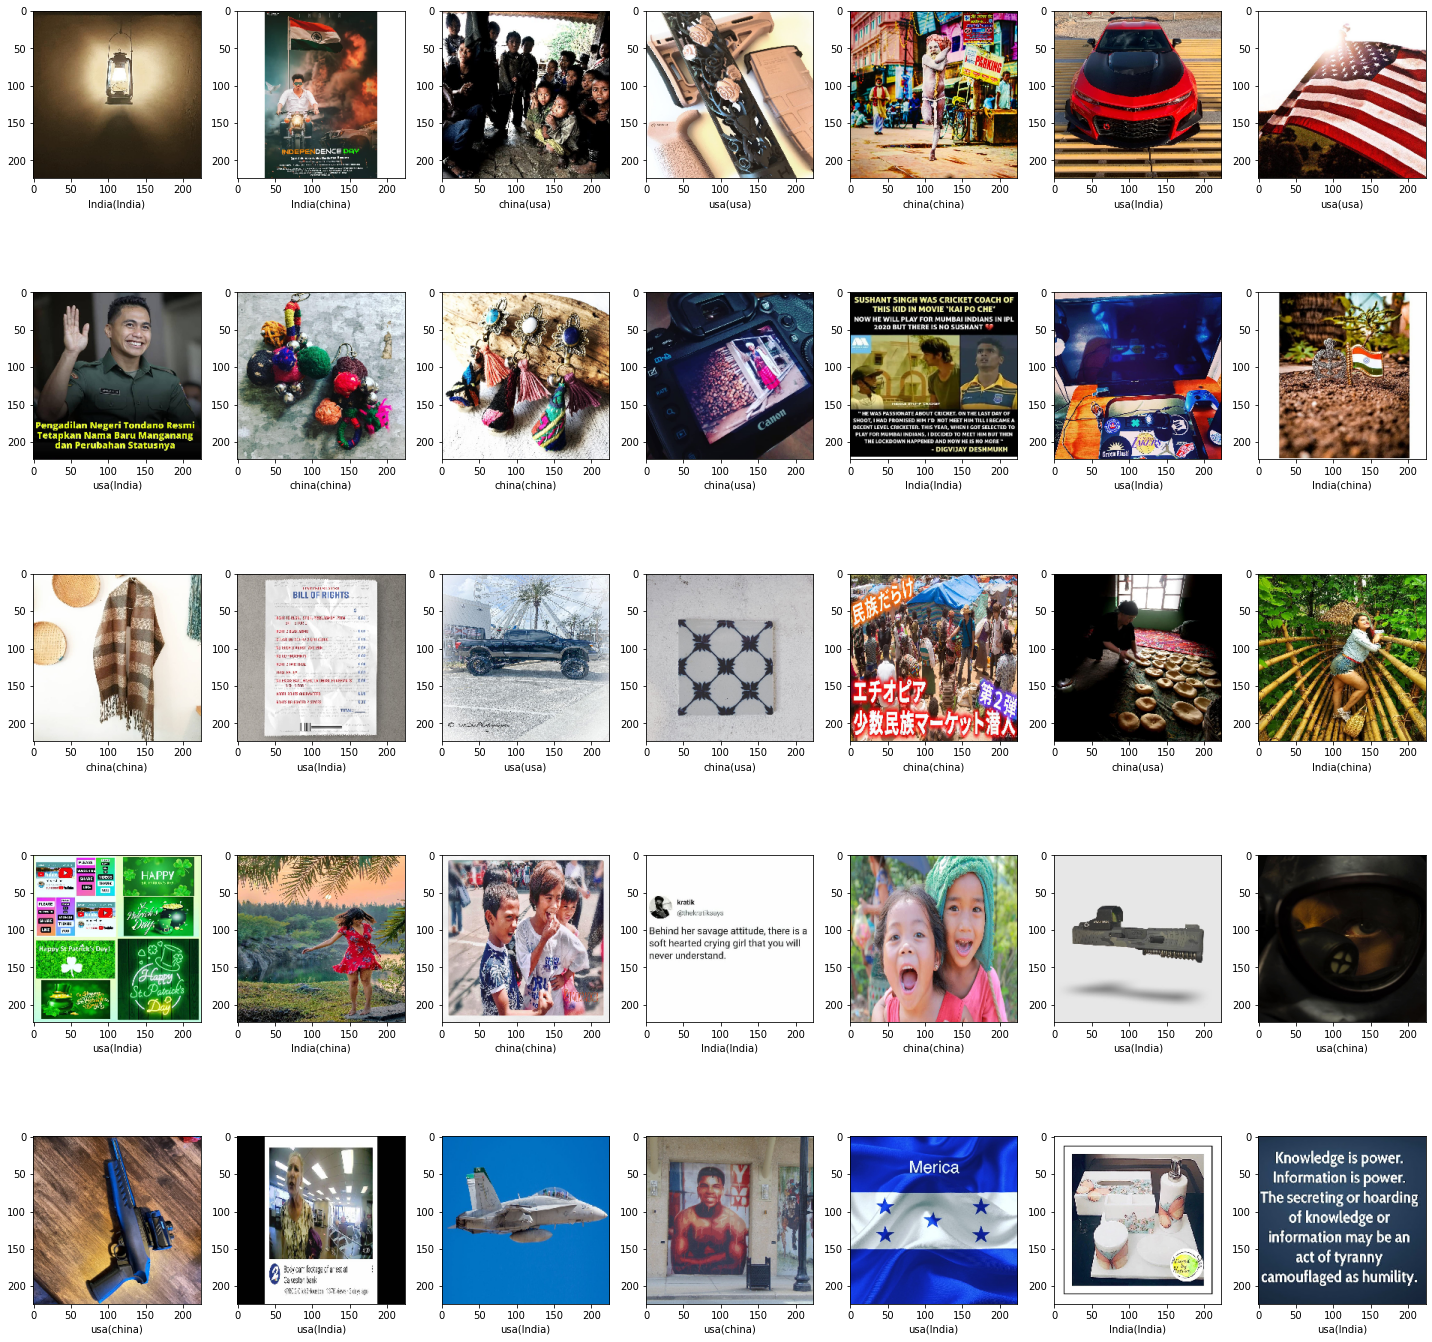

In [ ]:
from keras.preprocessing import image

sample_test = test_df.sample(n=35).reset_index(drop=True)
plt.figure(figsize=(20, 20))
for index, row in sample_test.iterrows():
    filename = row['filename']
    pred = row['pred']
    img = image.load_img(path + "/" + filename, target_size=(224,224))
    plt.subplot(5, 7, index+1)
    plt.imshow(img)
    plt.xlabel(filename.split(' ')[0] + '(' + "{}".format(pred) + ')' )
plt.tight_layout()
plt.show()

Found 1 validated image filenames belonging to 1 classes.


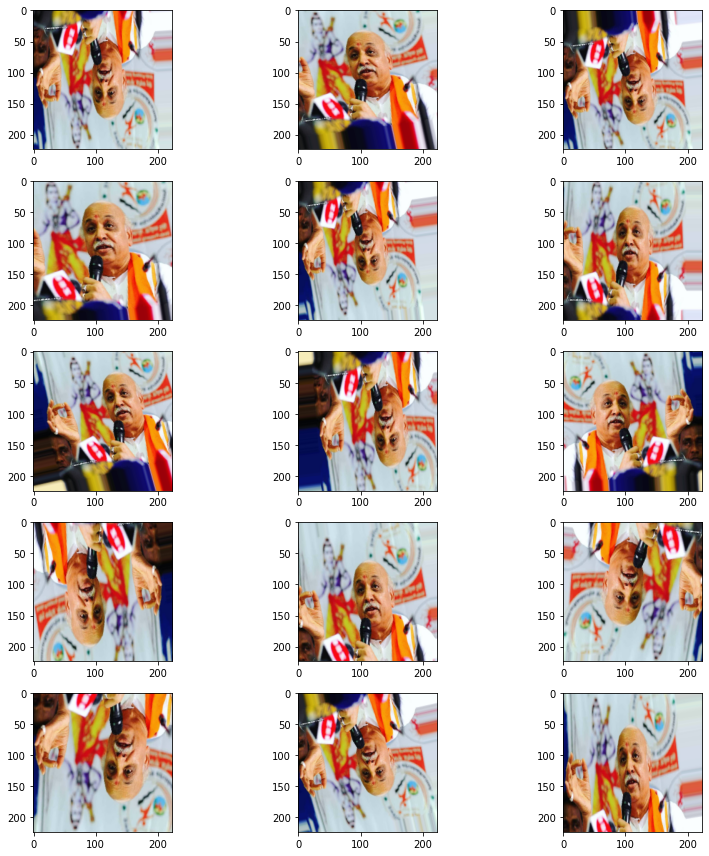

In [ ]:
# Image Augmentation
example_df = train_df.sample(n=1).reset_index(drop=True)
example_set = train_datagen.flow_from_dataframe(
    example_df, 
    path,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()